# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score, precision_score, recall_score, precision_recall_fscore_support, fbeta_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, make_scorer
from sklearn.inspection import permutation_importance

from scipy import stats

from PipelineObjects import *

In [2]:
# This sets the logging level for custom transformers defined in PipelineObjects
set_log_level(logging.WARN)

# Import Data

In [3]:
# Read in file while dropping the ones without a 'Make' field to reduce memory footprint
file = 'data.csv'

# Get the full dataset to generate the model. For shorter tests, read a smaller number of rows as below
df_raw = pd.DataFrame()
with pd.read_csv(file, chunksize=1000000) as chunks:
  for chunk in chunks:
    chunk.dropna(axis=0, subset=['Make'], inplace=True) # Dropping all rows with any NaN value
    df_raw = pd.concat([df_raw, chunk])
del chunks

# # For shorter tests, get only a small number of rows
# df_raw = pd.read_csv(file, nrows=50000)
# df_raw.dropna(subset='Make', inplace=True)

# This is used to get a continuous index on the raw dataframe
df_raw.reset_index(inplace=True, drop=True)

print(f'# Records: {len(df_raw)}')

/var/folders/62/f47g0twx1fn3vqf6gyvhx5780000gn/T/ipykernel_22875/1036430424.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/62/f47g0twx1fn3vqf6gyvhx5780000gn/T/ipykernel_22875/1036430424.py:7: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/62/f47g0twx1fn3vqf6gyvhx5780000gn/T/ipykernel_22875/1036430424.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/62/f47g0twx1fn3vqf6gyvhx5780000gn/T/ipykernel_22875/1036430424.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/62/f47g0twx1fn3vqf6gyvhx5780000gn/T/ipykernel_22875/1036430424.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=Fal

# Records: 4357544


## Set up target

1.0    0.914785
0.0    0.085215
Name: top25, dtype: float64


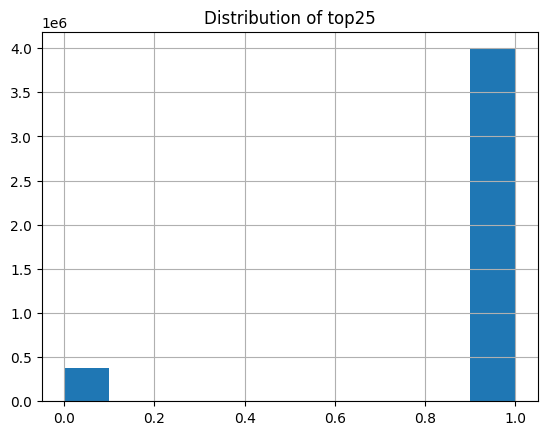

In [4]:
# Get set of top 25 manufacturers
top25 = set(df_raw['Make'].value_counts(dropna=True, ascending=False)[:25].index.to_list())

# If Make is in top 25 manufacturers, then set top25 to 1, else 0
cond = df_raw['Make'].isin(top25)
df_raw.loc[cond, 'top25'] = 1
df_raw.loc[~cond, 'top25'] = 0

# See distribution of top25
print(df_raw['top25'].value_counts(dropna=False)/len(df_raw))
plt.hist(x=df_raw['top25'])
plt.grid()
plt.title('Distribution of top25')
plt.show()

## Rename Columns

In [5]:
# Columns are renamed for better readability
col_rename = {
  'Ticket number': 'TicketNum',
  'Issue Date': 'IssueDate',
  'Issue time': 'IssueTime', 
  'Meter Id': 'MeterID', 
  'Marked Time': 'MarkedTime',
  'RP State Plate': 'StatePlate', 
  'Plate Expiry Date': 'PlateExpiration', 
  'Body Style': 'BodyStyle',
  'Violation code': 'ViolationCode',
  'Violation Description': 'ViolationDesc',
  'Fine amount': 'Fine',
}
df_raw.rename(columns=col_rename, inplace=True)

# set issue date as datetime type
df_raw['IssueDate'] = df_raw['IssueDate'].astype('datetime64[ns]')

## Drop identifier columns

In [6]:
to_drop = ['VIN', 'TicketNum']
df_raw.drop(columns=to_drop, inplace=True)

# Data Exploration

## Generic Properties

First 5 rows

In [7]:
df_raw.head()

,IssueDate,IssueTime,MeterID,MarkedTime,StatePlate,PlateExpiration,Make,BodyStyle,Color,Location,Route,Agency,ViolationCode,ViolationDesc,Fine,Latitude,Longitude,top25
0,2015-09-15,115.0,NaN,NaN,CA,200316.0,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0,1.0
1,2015-12-17,1710.0,NaN,NaN,CA,201605.0,MAZD,PA,BL,SUNSET/ALVARADO,00217,1.0,8070,PARK IN GRID LOCK ZN,163.0,99999.0,99999.0,1.0
2,2015-12-22,1100.0,NaN,NaN,CA,201511.0,FORD,TR,WH,1159 HUNTLEY DR,2A75,1.0,8069AA,NO STOP/STAND AM,93.0,99999.0,99999.0,1.0
3,2015-12-22,1105.0,NaN,NaN,CA,201701.0,CHRY,PA,GO,1159 HUNTLEY DR,2A75,1.0,8069AA,NO STOP/STAND AM,93.0,99999.0,99999.0,1.0
4,2015-12-27,1055.0,NaN,NaN,CA,201605.0,TOYO,PA,BK,3100 N HOLLYRIDGE DR,NaN,54.0,8058L,PREF PARKING,68.0,99999.0,99999.0,1.0


Description

In [8]:
df_raw.describe()

,IssueTime,MarkedTime,PlateExpiration,Agency,Fine,Latitude,Longitude,top25
count,4.356549e+06,144922.000000,3.960997e+06,4.357538e+06,4.354349e+06,4.357543e+06,4.357543e+06,4.357544e+06
mean,1.203880e+03,1055.147196,1.867826e+05,5.203218e+01,7.010876e+01,5.503485e+06,1.587400e+06,9.147846e-01
std,4.722652e+02,227.166905,5.276190e+04,9.238550e+00,3.205594e+01,3.025596e+06,2.098413e+06,2.792020e-01
min,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+01,9.999900e+04,9.999900e+04,0.000000e+00
25%,9.120000e+02,910.000000,2.016010e+05,5.100000e+01,6.300000e+01,6.421524e+06,1.821596e+06,1.000000e+00
50%,1.155000e+03,1036.000000,2.017020e+05,5.400000e+01,6.800000e+01,6.451586e+06,1.841993e+06,1.000000e+00
75%,1.511000e+03,1200.000000,2.018030e+05,5.500000e+01,7.300000e+01,6.475013e+06,1.858208e+06,1.000000e+00
max,2.359000e+03,2400.000000,5.015120e+05,9.700000e+01,5.050000e+02,4.042322e+09,4.042322e+09,1.000000e+00


Data types

In [9]:
df_raw.dtypes

IssueDate          datetime64[ns]
IssueTime                 float64
MeterID                    object
MarkedTime                float64
StatePlate                 object
PlateExpiration           float64
Make                       object
BodyStyle                  object
Color                      object
Location                   object
Route                      object
Agency                    float64
ViolationCode              object
ViolationDesc              object
Fine                      float64
Latitude                  float64
Longitude                 float64
top25                     float64
dtype: object

Missing values

In [10]:

# Get the percentage of each column that is missing (sorted in descending order)
missing = df_raw.isna().mean().sort_values(ascending=False)
cond = missing != 0
missing[cond]

MarkedTime         9.667423e-01
MeterID            7.397963e-01
PlateExpiration    9.100241e-02
Route              7.269462e-03
BodyStyle          9.156534e-04
Fine               7.332112e-04
Color              3.474434e-04
IssueTime          2.283396e-04
ViolationDesc      9.890893e-05
StatePlate         8.972944e-05
Location           3.419357e-05
Agency             1.376922e-06
Longitude          2.294871e-07
Latitude           2.294871e-07
dtype: float64

In [11]:
# Drop MarkedTime since over 95% of it is missing anyway
df_raw.drop(columns=['MarkedTime'], inplace=True)

Correlations

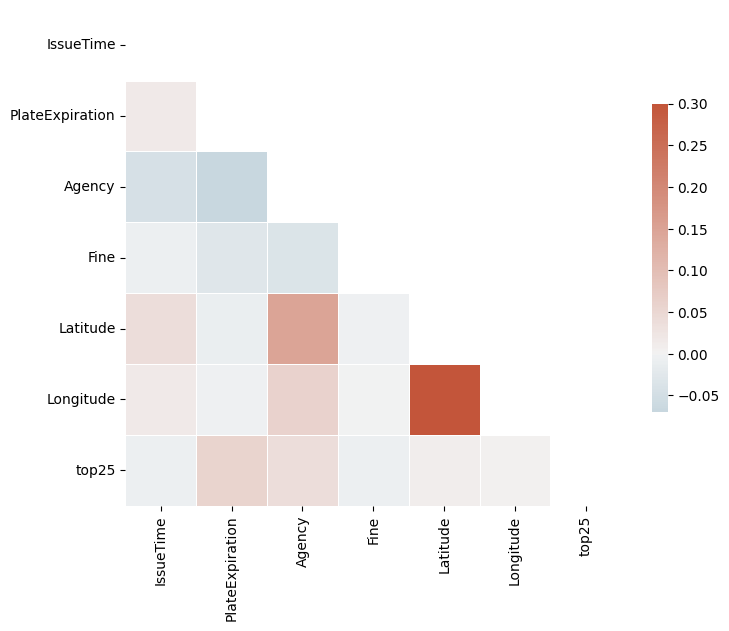

In [12]:
# Get correations
corr = df_raw.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Features

The features `['BodyStyle', 'Color', 'StatePlate']` seem most promising as shown below

### Categorical

In [13]:
# Check dimensionality for each categorical variable. This is useful to see which features are too fragmented for OHE
for _ in df_raw.select_dtypes(exclude=['float', 'int']).columns:
  print(f'{_}: {len(df_raw[_].value_counts(dropna=False))}')

IssueDate: 1724
MeterID: 36457
StatePlate: 78
Make: 1477
BodyStyle: 146
Color: 81
Location: 1047758
Route: 6796
ViolationCode: 282
ViolationDesc: 601


In [14]:
# Exploring the StatePlate feature since that is higher than expected:
# copied list of state codes from from https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm
# These frequencies are low enough and will be taken care of by the aggregation.

states = set(['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT','VT','VA','VI','WA','WV','WI','WY'])

ll = df_raw['StatePlate'].value_counts(dropna=False)
for i, v in ll.iteritems():
  if i not in states:
    print(i, v)

MX 3703
BC 1336
ON 988
VN 915
AB 864
nan 391
QU 358
US 189
FN 188
NB 81
CN 81
MB 76
SA 72
XX 63
NS 31
CZ 15
PE 12
GU 12
TT 11
NW 11
AS 8
NF 7
YU 3
| 1
ML 1


In [15]:
# Applying the category aggregator to the features of interest reduces the cardinality.
# The thresholds were chosen to get 4-6 values per feature.
aggregators = {
  'BodyStyle': CategoryAggregator(cols=['BodyStyle'], threshold=0.99, convert_num=False),
  'Color': CategoryAggregator(cols=['Color'], threshold=0.85, convert_num=False),
  'StatePlate': CategoryAggregator(cols=['StatePlate'], threshold=0.96, convert_num=False),
}

for col, agg in aggregators.items():
  print(col)
  print(agg.fit_transform(df_raw[[col]]).value_counts(dropna=False))
  print('---')

BodyStyle
BodyStyle
PA           3834173
PU            149403
VN            116413
TK            106140
CM             70165
Other          52906
TR             28344
dtype: int64
---
Color
Color
BK       940001
WT       904267
GY       844745
Other    783226
SL       546397
BL       338908
dtype: int64
---
StatePlate
StatePlate
CA            4058883
Other          187160
AZ              38914
TX              27415
NV              26067
FL              19105
dtype: int64
---


### Numerical

IssueTime


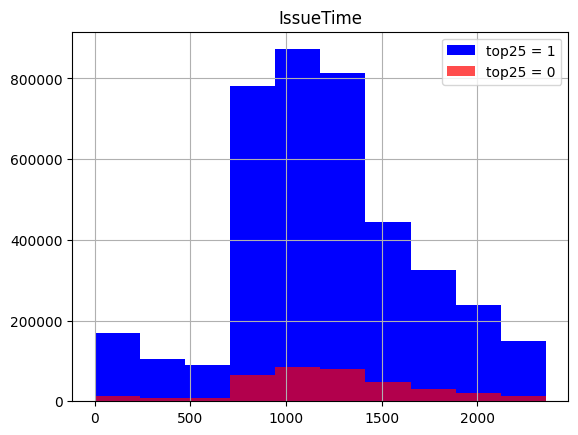

PlateExpiration


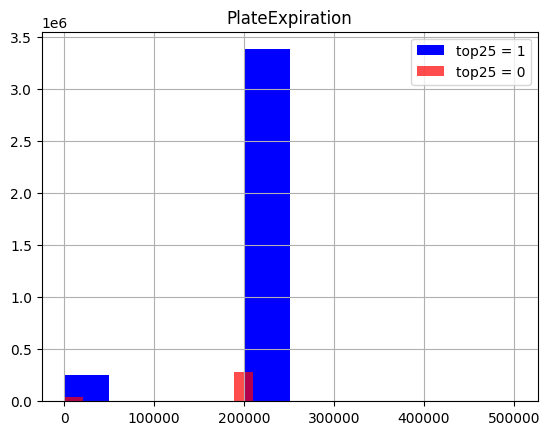

Agency


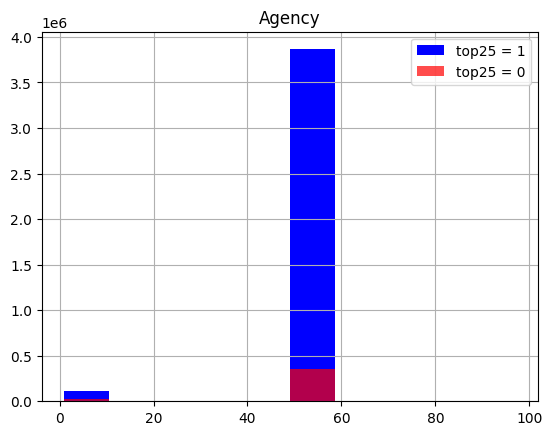

Fine


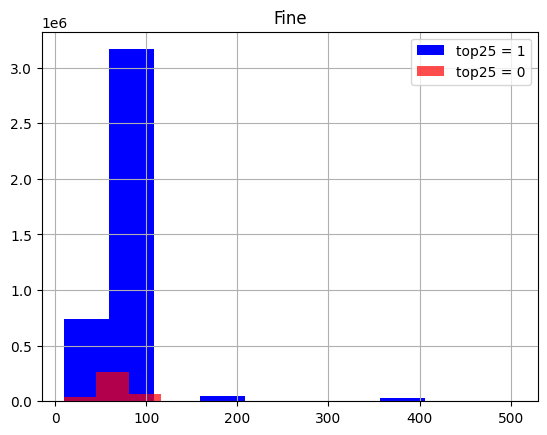

Latitude


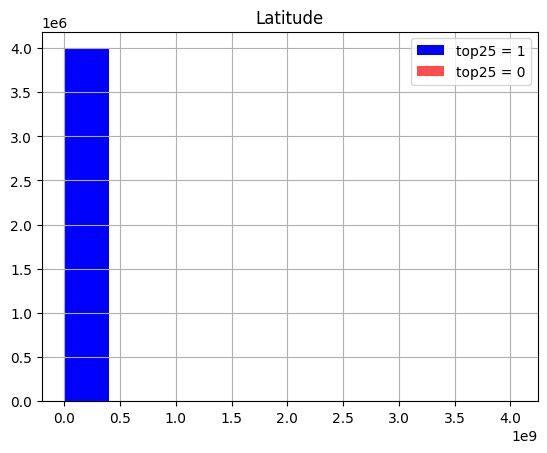

Longitude


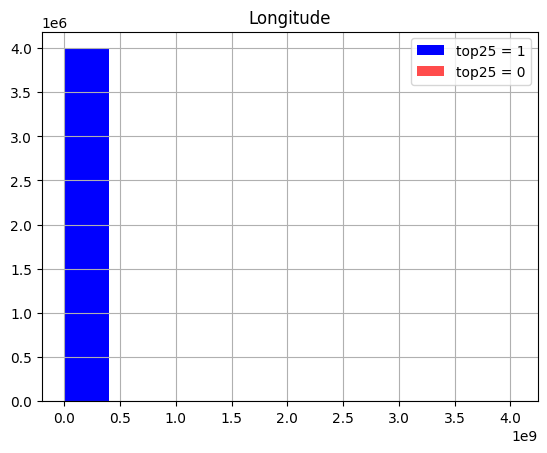

top25


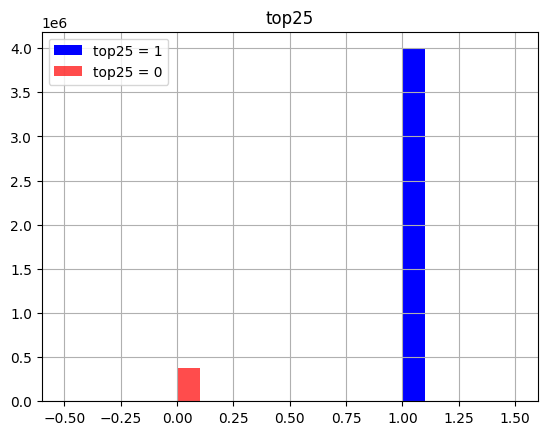

In [16]:
for _ in df_raw.select_dtypes(include=['float', 'int']).columns:
  cond = df_raw['top25'] == 1
  print(_)
  plt.hist(x=df_raw[cond][_], color='blue', alpha=1.0, label='top25 = 1')
  plt.hist(x=df_raw[~cond][_], color='red', alpha=0.7, label='top25 = 0')
  plt.title(_)
  plt.grid()
  plt.legend()
  plt.show()

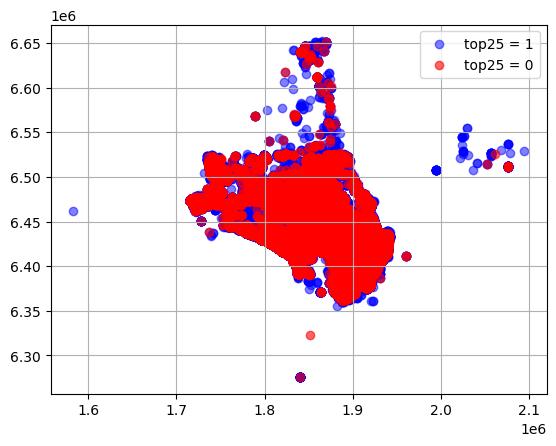

In [17]:
# There does not seem to be any correlation between top25 and Latitude / Longitude
# There are a number of outliers that affect the scale of the plot. The condition below only selects records that are within a certain number of standard deviations from the mean.
cond = (
  (abs(stats.zscore(df_raw['Latitude'], nan_policy='omit')) < 1.2) & 
  (abs(stats.zscore(df_raw['Longitude'], nan_policy='omit')) < 1.2)
)

cond0 = df_raw['top25'] == 0
cond1 = df_raw['top25'] == 1

plt.scatter(df_raw[cond & cond1]['Longitude'], df_raw[cond & cond1]['Latitude'], color='blue', label='top25 = 1', alpha=0.5)
plt.scatter(df_raw[cond & cond0]['Longitude'], df_raw[cond & cond0]['Latitude'], color='red', label='top25 = 0', alpha=0.6)
plt.legend()
plt.grid()
plt.show()

# Modeling

## Set up training / test set and input features

In [18]:
input_features = ['BodyStyle', 'Color', 'StatePlate']

X = df_raw[input_features].copy()
y = df_raw['top25'].copy()

# Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

## Set up pipeline

Some custom transformers (defined in `./PipelineObjects.py`) are used here.

In [19]:
# A feature selector lets the user have an arbitrary input, the model only picks up the features it needs
feature_selector = FeatureSelector(features=input_features)

# This aggregates the values in a given column as 'other' once the given threshold is met. The convert_num flag is used to convert a given category to a numerical value (frequency )
# Some testing is done to get the threshold so the aggregate categories have 4-6 unique values
agg_body = CategoryAggregator(cols=['BodyStyle'], threshold=0.99, convert_num=False)
agg_color = CategoryAggregator(cols=['Color'], threshold=0.85, convert_num=False)
agg_state = CategoryAggregator(cols=['StatePlate'], threshold=0.96, convert_num=False)


# Set up generic numeric and categorical transformers for imputation, scaling, and OHE
numeric_transformer = Pipeline(
  steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(sparse=False, handle_unknown="ignore", drop='if_binary')),
  ]
)

final_transformer = ColumnTransformer(
  [
    # final transformations            
    ("numerical", numeric_transformer, make_column_selector(dtype_include=['float', 'int'])),
    ("categorical", categorical_transformer, make_column_selector(dtype_include=['category'])),

  ],
  remainder="passthrough",
)

# Set up model
model = RandomForestClassifier( 
  n_estimators=100,
  min_samples_leaf=15,
  max_features="sqrt",
  n_jobs=-1,
  random_state=42
)

# Combine all transformers and model into a pipeline
pipe = Pipeline(
  [
    ('feature_selector', feature_selector),
    ('agg_body',agg_body), 
    ('agg_color',agg_color), 
    ('agg_state',agg_state), 
    ('final_transformer', final_transformer),
    ('model', model)
  ]
)

## Fit Pipeline

In [20]:
sample_size = len(X_train)
pipe.fit(X_train[:sample_size], y_train[:sample_size])

Pipeline(steps=[('feature_selector',
                 FeatureSelector(features=['BodyStyle', 'Color',
                                           'StatePlate'])),
                ('agg_body',
                 CategoryAggregator(cols=['BodyStyle'], threshold=0.99)),
                ('agg_color',
                 CategoryAggregator(cols=['Color'], threshold=0.85)),
                ('agg_state',
                 CategoryAggregator(cols=['StatePlate'], threshold=0.96)),
                ('final_transformer',
                 ColumnTransformer(remainder='pa...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12e5f43d0>),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12e5f47f0>)])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=15, n_jobs=-1,
                                        random_state=42))])

# Metrics

In [21]:
metrics = {}
y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

## ROC

ROC AUC: 0.6574


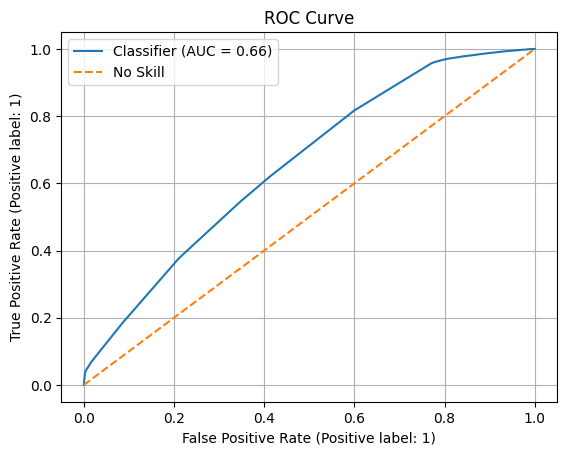

In [22]:
metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {metrics['roc_auc']:0.4f}")

RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title(f'ROC Curve')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.legend()
plt.grid()
plt.savefig('./plots/ROC.png')
plt.show()

## Precision Recall

ROC AUC: 0.9458


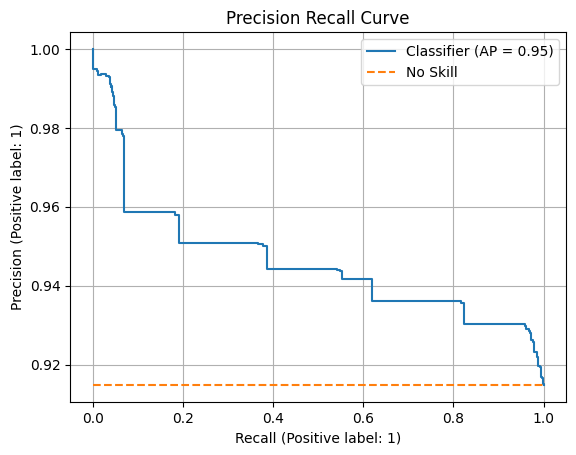

In [23]:
metrics['avg_prec'] = average_precision_score(y_test, y_pred_proba)
print(f"ROC AUC: {metrics['avg_prec']:0.4f}")

baseline=np.sum(y_test==1)/len(y_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title(f'Precision Recall Curve')
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='No Skill')
plt.legend()
plt.grid()
plt.savefig('./plots/PrecisionRecall.png')
plt.show()

## Accuracy

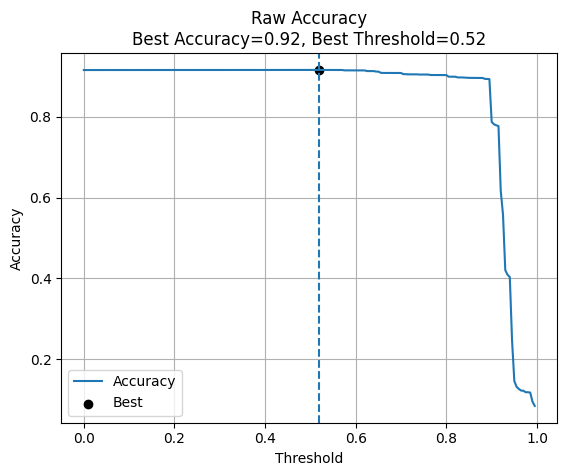

In [24]:
thresholds = np.arange(0, 1, 0.005)
accuracies = [accuracy_score(y_test, y_pred_proba > t) for t in thresholds]
idx = np.argmax(accuracies)
optimal_threshold = thresholds[idx]
optimal_metric = accuracies[idx]
plt.plot(thresholds, accuracies, label='Accuracy')
plt.title(f'Raw Accuracy\nBest Accuracy={optimal_metric:0.2f}, Best Threshold={optimal_threshold:0.2f}')
plt.scatter(optimal_threshold, optimal_metric, label=f'Best', color='black')
plt.axvline(optimal_threshold, linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.savefig('./plots/Accuracy.png')
plt.show()

## Confusion Matrix

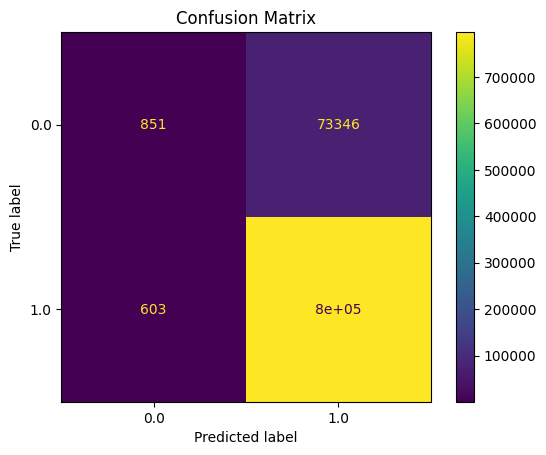

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Confusion Matrix')
plt.savefig('./plots/ConfusionMatrix.png')
plt.show()

## Feature Importances

In [26]:
def get_col_names(X, pipe):
  X_ = X.copy()
  # assumes final_transformer and then model are the last two steps
  for i in range(len(pipe)-2):
    X_ = pipe[i].transform(X_)

  # select the cols that will be input to the OHE and use get_feature_names_out to transform them to the ohe encoded versions
  cat_cols = X_.select_dtypes(exclude=['float', 'int']).columns
  ohe_cols = pipe.named_steps['final_transformer'].named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(cat_cols)

  # get the full list of columns (numeric and ohe-encoded)
  full_list = X_.select_dtypes(include=['float', 'int']).columns.to_list()+list(ohe_cols)
  return full_list

feature_names = get_col_names(X, pipe)

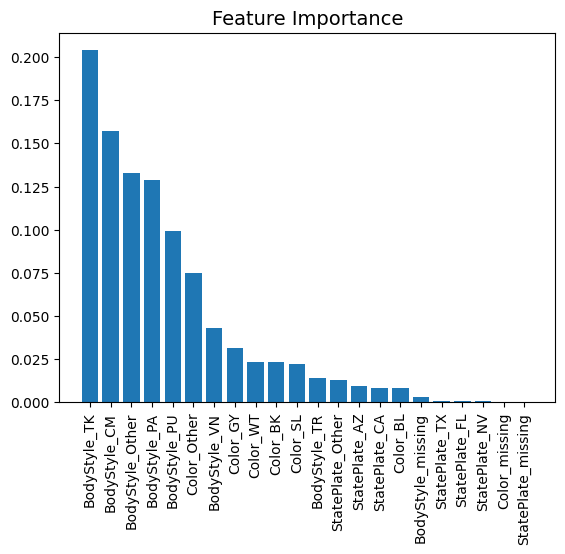

In [27]:
# importances = pipe['model'].coef_[0]
importances = pipe['model'].feature_importances_
sorted_idx = (-abs(importances)).argsort()
feature_imp_df = pd.DataFrame({'features': np.array(feature_names)[sorted_idx], 'importances': importances[sorted_idx]}, feature_names)
plt.xticks(rotation='vertical')
plt.title('Feature Importance', fontsize=14)
plt.bar(feature_imp_df.features, feature_imp_df.importances)
plt.savefig('./plots/FeatureImportance.png')


## Metrics Summary

In [28]:
pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

,Value
roc_auc,0.657367
avg_prec,0.945815


# Save Model

In [29]:
file = 'model.pkl'
pickle.dump(pipe, open(file, 'wb'))